In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from google.colab import drive



In [3]:
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!pip install gdown
!gdown 'https://drive.google.com/uc?id=FILE_ID'


Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=FILE_ID

but Gdown can't. Please check connections and permissions.


In [5]:
!gdown --fuzzy 'https://drive.google.com/file/d/1Da7faCjb5FdjAEVjwfwzPemMwMa1DVT9/view?usp=sharing'


Downloading...
From (original): https://drive.google.com/uc?id=1Da7faCjb5FdjAEVjwfwzPemMwMa1DVT9
From (redirected): https://drive.google.com/uc?id=1Da7faCjb5FdjAEVjwfwzPemMwMa1DVT9&confirm=t&uuid=5aaf165e-2f12-4f3b-8b45-3e25145b84c4
To: /content/merged_data.csv
100% 1.66G/1.66G [00:05<00:00, 289MB/s]


Below cell is not required for now

In [ ]:
# Install gdown if not already installed
!pip install gdown

# Download the CSV file using gdown and the file ID
import gdown

file_id = 'YOUR_FILE_ID'  # Replace this with the actual file ID from the shared link
url = f'https://drive.google.com/uc?id={file_id}'
output = 'data.csv'  # Name of the file to save locally
gdown.download(url, output, quiet=False)

# Load the CSV into a DataFrame
import pandas as pd

data = pd.read_csv(output)
print(data.head())


Above cell is not required for now


In [10]:

# Step 1: Load and preprocess data
# Load the data
df = pd.read_csv('/content/merged_data.csv')  # Replace with your CSV file path

In [11]:



# Basic data exploration
print(df.head())
print(df.info())
print(df.describe())

# Assuming the last column is the target and the rest are features
X = df.iloc[:, :-1]  # Features (gene expression data)
y = df.iloc[:, -1]   # Target (cancer presence/absence)

# Encode target variable if it is categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

           gene_ID              Sample  FPKM  Cancer_Type_Breast  \
0  ENSG00000000003  3-Breast-Her2-ampl     0                True   
1  ENSG00000000005  3-Breast-Her2-ampl     0                True   
2  ENSG00000000419  3-Breast-Her2-ampl    44                True   
3  ENSG00000000457  3-Breast-Her2-ampl    26                True   
4  ENSG00000000460  3-Breast-Her2-ampl    81                True   

   Cancer_Type_CRC  Cancer_Type_GBM  Cancer_Type_HC  \
0            False            False           False   
1            False            False           False   
2            False            False           False   
3            False            False           False   
4            False            False           False   

   Cancer_Type_Hepatobiliary  Cancer_Type_Lung  Cancer_Type_Pancreas  \
0                      False             False                 False   
1                      False             False                 False   
2                      False             Fal

In [12]:
print("Available columns in the DataFrame:")
print(df.columns)


Available columns in the DataFrame:
Index(['gene_ID', 'Sample', 'FPKM', 'Cancer_Type_Breast', 'Cancer_Type_CRC',
       'Cancer_Type_GBM', 'Cancer_Type_HC', 'Cancer_Type_Hepatobiliary',
       'Cancer_Type_Lung', 'Cancer_Type_Pancreas',
       'Cancer_Type_mutational subclass: EGFR',
       'Cancer_Type_mutational subclass: HER2+',
       'Cancer_Type_mutational subclass: KRAS',
       'Cancer_Type_mutational subclass: PIK3CA',
       'Cancer_Type_mutational subclass: wt'],
      dtype='object')


In [13]:


# Create a single target column indicating the cancer type
cancer_types = [col for col in df.columns if col.startswith('Cancer_Type_')]
df['Cancer_Type'] = df[cancer_types].idxmax(axis=1)  # Assign the column name of the max value

# Filter out samples with no cancer type indicated
df = df[df['Cancer_Type'].notna()]

# Prepare features and target
X = df[['gene_ID', 'FPKM']]
y = df['Cancer_Type']

# Encode categorical features and target
X['gene_ID'] = LabelEncoder().fit_transform(X['gene_ID'])  # Encode gene IDs as numerical values
y = LabelEncoder().fit_transform(y)  # Encode cancer types as numerical labels

# Scale numeric feature (FPKM)
scaler = StandardScaler()
X['FPKM'] = scaler.fit_transform(X[['FPKM']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data preparation complete. Ready for model training.")


<ipython-input-13-cdcc3d132bae>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['gene_ID'] = LabelEncoder().fit_transform(X['gene_ID'])  # Encode gene IDs as numerical values
<ipython-input-13-cdcc3d132bae>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FPKM'] = scaler.fit_transform(X[['FPKM']])


Data preparation complete. Ready for model training.


In [14]:


# Step 4: Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:30:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [16]:

# XGBoost evaluation
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.12      0.00      0.00    277169
           1       0.15      0.00      0.00    438176
           2       0.16      0.00      0.00    462381
           3       0.19      0.99      0.32    634497
           4       0.00      0.00      0.00    150272
           5       0.16      0.01      0.02    461480
           6       0.13      0.00      0.00    404471
           7       0.08      0.00      0.00    104135
           8       0.00      0.00      0.00     69626
           9       0.17      0.00      0.00    127014
          10       0.00      0.00      0.00     22932
          11       0.27      0.00      0.00    138799

    accuracy                           0.19   3290952
   macro avg       0.12      0.08      0.03   3290952
weighted avg       0.15      0.19      0.07   3290952

Confusion Matrix:
[[    13    537    103 272971      1   3314    229      1      0      0
       0      0]
 [    20    811    167 431

In [17]:

# XGBoost evaluation
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.12      0.00      0.00    277169
           1       0.15      0.00      0.00    438176
           2       0.16      0.00      0.00    462381
           3       0.19      0.99      0.32    634497
           4       0.00      0.00      0.00    150272
           5       0.16      0.01      0.02    461480
           6       0.13      0.00      0.00    404471
           7       0.08      0.00      0.00    104135
           8       0.00      0.00      0.00     69626
           9       0.17      0.00      0.00    127014
          10       0.00      0.00      0.00     22932
          11       0.27      0.00      0.00    138799

    accuracy                           0.19   3290952
   macro avg       0.12      0.08      0.03   3290952
weighted avg       0.15      0.19      0.07   3290952

Confusion Matrix:
[[    13    537    103 272971      1   3314    229      1      0      0
       0      0]
 [    20    811    167 431

In [19]:
pip install seaborn


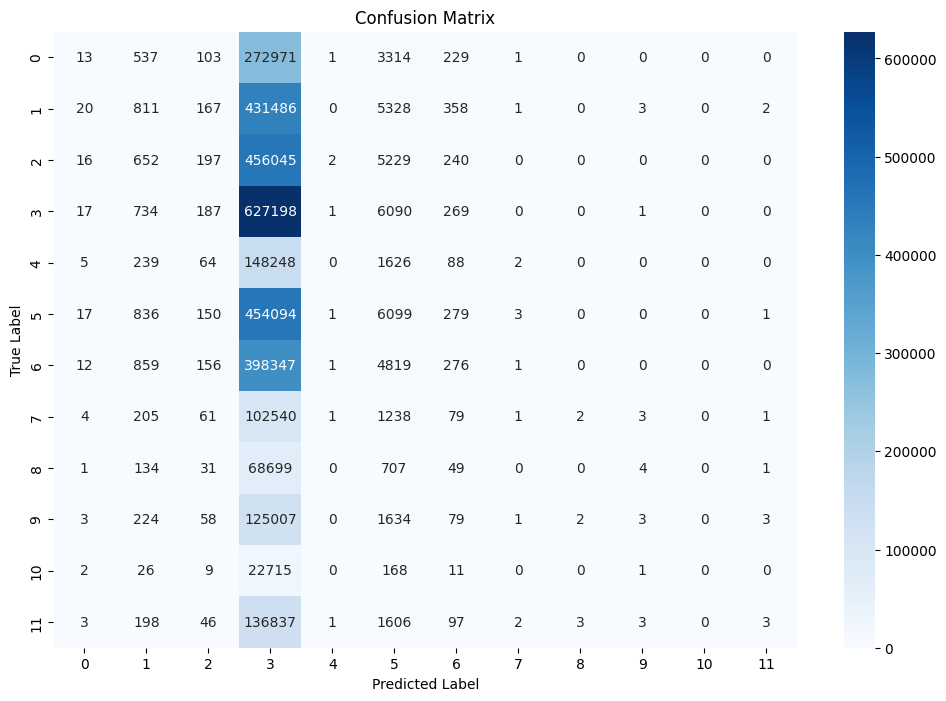

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


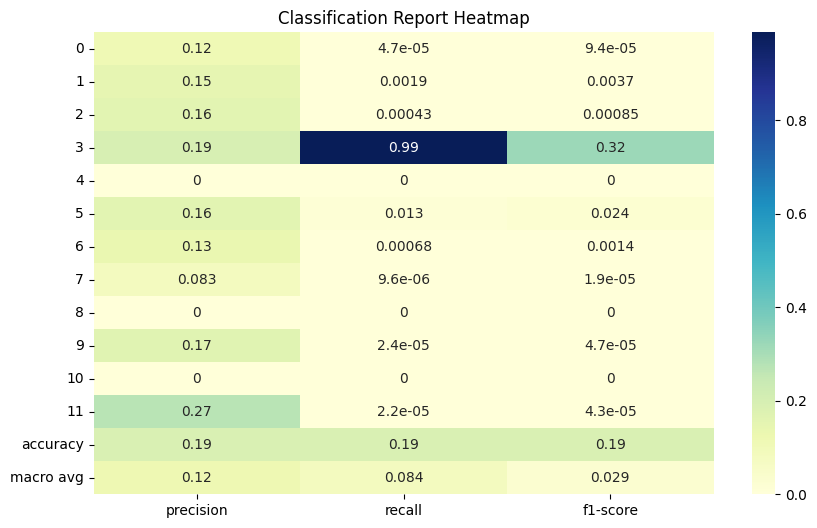

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions for the test set
y_pred_xgb = xgb_model.predict(X_test)

# Create and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Display the classification report as a heatmap
report = classification_report(y_test, y_pred_xgb, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.show()
